## Data
The data is available as two attached CSV files:
* takehome_user_engagement.csv
* takehome_users.csv

1.The data has the following two tables:
A user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years. This table includes:
* name: the user's name
* object_id: the user's id
* email: email address
* creation_source: how their account was created. This takes on one of 5 values:
    * PERSONAL_PROJECTS: invited to join another user's personal workspace
    * GUEST_INVITE: invited to an organization as a guest (limited permissions)
    * ORG_INVITE: invited to an organization (as a full member)
    * SIGNUP: signed up via the website
    * SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
* creation_time: when they created their account
* last_session_creation_time: unix timestamp of last login
* opted_in_to_mailing_list: whether they have opted into receiving marketing emails
* enabled_for_marketing_drip: whether they are on the regular marketing email drip
* org_id: the organization (group of users) they belong to
* invited_by_user_id: which user invited them to join (if applicable).

2.A usage summary table ( "takehome_user_engagement" ) that has a row for each day that a user logged into the product.

## Goal
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period, identify which factors predict future user adoption.

## Import Packages

In [32]:
from glob import glob
import pandas as pd
import numpy as np
from sklearn import preprocessing

try:
    import cPickle as pickle
except ImportError:  # python 3.x
    import pickle

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
palette = sns.diverging_palette(220, 20, sep = 20, n = 150)
sns.set_palette(palette)

In [33]:
def get_sub_plot(width = 16, height = 5, label_font_size = 14, tick_font_size = 13):
    fig, ax = plt.subplots()
    fig.set_size_inches(width, height)
    ax.tick_params(labelsize = tick_font_size)
    ax.set_xlabel(ax.get_xlabel(), fontsize = label_font_size)
    ax.set_ylabel(ax.get_ylabel(), fontsize = label_font_size)
    return ax

def plot_scatter(x, y, data):
    ax = get_sub_plot()
    sns.regplot(x = x, y = y, fit_reg = False,
            x_jitter = .0, y_jitter = .1,
            data = data, ax = ax)
    plt.show()

## Load Data

In [34]:
df_users = pd.read_csv('/Users/KATMER/Desktop/github/github/TakeHome_Challenges/relax_challenge/takehome_users.csv', encoding = "ISO-8859-1")
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [35]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [36]:
df_engage = pd.read_csv('/Users/KATMER/Desktop/github/github/TakeHome_Challenges/relax_challenge/Takehome_user_engagement.csv', encoding = "ISO-8859-1", parse_dates = ['time_stamp'])
df_engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [37]:
df_engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


## Define Adopted Users
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period, identify which factors predict future user adoption.

In [38]:
# first get all user ids
users = set(df_engage['user_id'])
adopted_user = []

# iterate all users & check whether they are 'adopted user' using panda's API 'rolling'
for i, user in enumerate(users):
    df_user = df_engage[df_engage.user_id == user]
    df_user = df_user[['time_stamp', 'user_id']]
    df_user['time_stamp'] = pd.to_datetime(df_user['time_stamp'])
    df_user = df_user.set_index('time_stamp')
    df_user['at_least_3_days_over_7_days_period'] = df_user.rolling(window = '7D').count()
    
    if max(df_user['at_least_3_days_over_7_days_period']) >= 3:
        adopted_user.append(user)
        
print(len(adopted_user) / len(users) * 100)

18.157089425365523


About 18% of users are considered adopted users.

## Identify Factors that Predict Future User Adoption

In [39]:
# Map the adopted user information back to the user data frame as 'is_adopted_user'.
df_users['is_adopted_user'] = df_users['object_id'].apply(lambda x: x in adopted_user)
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False


In [40]:
# select features/target.
# remove name as in terms of privacy it should NOT be a feature.
df_users = df_users[['creation_time', 'email', 'creation_source', 'last_session_creation_time', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'is_adopted_user',]]
df_users.head()

,creation_time,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,is_adopted_user
0,2014-04-22 03:53:30,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,False
1,2013-11-15 03:45:04,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,True
2,2013-03-19 23:14:52,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,False
3,2013-05-21 08:09:28,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,False
4,2013-01-17 10:14:20,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,False


In [41]:
# Inspect data types & fix them
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
creation_time                 12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
is_adopted_user               12000 non-null bool
dtypes: bool(1), float64(1), int64(3), object(3)
memory usage: 668.1+ KB


'org_id', 'opted_in_to_mailing_list' & 'enabled_for_marketing_drip' already have the right data types.
Let's fix the rest:

In [42]:
# Transform creation_time to datatime obj.
df_users['creation_time'] = pd.to_datetime(df_users['creation_time'])
df_user.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1 entries, 2014-01-26 08:57:12 to 2014-01-26 08:57:12
Data columns (total 2 columns):
user_id                               1 non-null int64
at_least_3_days_over_7_days_period    1 non-null float64
dtypes: float64(1), int64(1)
memory usage: 24.0 bytes


                     is_adopted_user
creation_time                       
2014-04-22 03:53:30              0.0
2013-11-15 03:45:04              1.0
2013-03-19 23:14:52              0.0
2013-05-21 08:09:28              0.0
2013-01-17 10:14:20              0.0


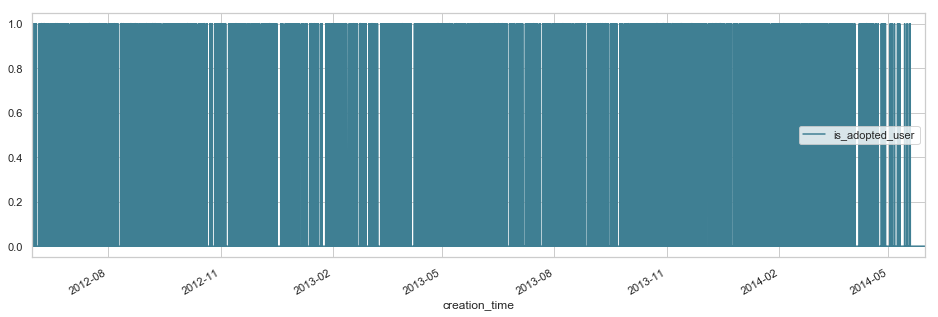

In [43]:
# Not sure if creation_time correlates adopted user. Let's quickly plot it to visualize it.
df_creation_time_vs_is_adopted_user = df_users[['creation_time', 'is_adopted_user']]
df_creation_time_vs_is_adopted_user = df_creation_time_vs_is_adopted_user.set_index('creation_time')
df_creation_time_vs_is_adopted_user['is_adopted_user'] = df_creation_time_vs_is_adopted_user['is_adopted_user'].astype(float)
print(df_creation_time_vs_is_adopted_user.head())

df_creation_time_vs_is_adopted_user.plot(figsize = (16, 5))

Seems not correlated. Let's drop it.

In [44]:
# For email, let's preserve the domain name & convert it into one hot encoder.
import re
df_users['email_domain_name'] = df_users['email'].apply(lambda x: re.search("@[\w.]+", x).group(0))
df_users.head()

,creation_time,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,is_adopted_user,email_domain_name
0,2014-04-22 03:53:30,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,False,@yahoo.com
1,2013-11-15 03:45:04,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,True,@gustr.com
2,2013-03-19 23:14:52,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,False,@gustr.com
3,2013-05-21 08:09:28,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,False,@yahoo.com
4,2013-01-17 10:14:20,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,False,@yahoo.com


In [45]:
# then for the email domain name we can apply one hot encoder to it.
df_users = pd.get_dummies(df_users, columns = ['email_domain_name'])
df_users.head()

,creation_time,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,is_adopted_user,email_domain_name_@abdnf.com,email_domain_name_@adpql.com,...,email_domain_name_@zkcdj.com,email_domain_name_@zkcep.com,email_domain_name_@zkdih.com,email_domain_name_@zpbkw.com,email_domain_name_@zpcop.com,email_domain_name_@zpcpu.com,email_domain_name_@zsrfb.com,email_domain_name_@zsrgb.com,email_domain_name_@zssin.com,email_domain_name_@zwmry.com
0,2014-04-22 03:53:30,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,False,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2013-11-15 03:45:04,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,True,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-03-19 23:14:52,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,False,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-05-21 08:09:28,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,False,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-17 10:14:20,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,False,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
# Similarly, creation_source is a categorical data and we can apply one hot encoder to it as well
df_users = pd.get_dummies(df_users, columns = ['creation_source'])
df_users.head()

,creation_time,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,is_adopted_user,email_domain_name_@abdnf.com,email_domain_name_@adpql.com,email_domain_name_@aerbd.com,...,email_domain_name_@zpcpu.com,email_domain_name_@zsrfb.com,email_domain_name_@zsrgb.com,email_domain_name_@zssin.com,email_domain_name_@zwmry.com,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,2014-04-22 03:53:30,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,False,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2013-11-15 03:45:04,MatthewPoole@gustr.com,1.396238e+09,0,0,1,True,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2013-03-19 23:14:52,MitchellBottrill@gustr.com,1.363735e+09,0,0,94,False,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,2013-05-21 08:09:28,NicklasSClausen@yahoo.com,1.369210e+09,0,0,1,False,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,2013-01-17 10:14:20,GraceRaw@yahoo.com,1.358850e+09,0,0,193,False,0,0,0,...,0,0,0,0,0,1,0,0,0,0


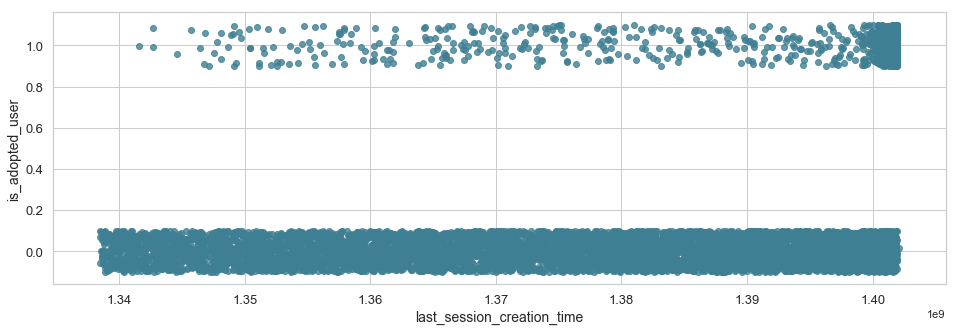

In [47]:
# For last_session_creation_time, not sure whether it's a good feature, let's quickly plot it to visualize it.
plot_scatter(x = "last_session_creation_time", y = "is_adopted_user", data = df_users)

It does not seem to be a good feature as there seems no correlation. Let's drop it.

In [48]:
# orig_id is also a categorical data. Let's apply one hot encoder to it.
df_users = pd.get_dummies(df_users, columns = ['org_id'])
df_users.head()

,creation_time,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,is_adopted_user,email_domain_name_@abdnf.com,email_domain_name_@adpql.com,email_domain_name_@aerbd.com,email_domain_name_@aethf.com,...,org_id_407,org_id_408,org_id_409,org_id_410,org_id_411,org_id_412,org_id_413,org_id_414,org_id_415,org_id_416
0,2014-04-22 03:53:30,AugustCClausen@yahoo.com,1.398139e+09,1,0,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2013-11-15 03:45:04,MatthewPoole@gustr.com,1.396238e+09,0,0,True,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-03-19 23:14:52,MitchellBottrill@gustr.com,1.363735e+09,0,0,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-05-21 08:09:28,NicklasSClausen@yahoo.com,1.369210e+09,0,0,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-17 10:14:20,GraceRaw@yahoo.com,1.358850e+09,0,0,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
# drop unnecessary features.
df_users = df_users.drop(['creation_time', 'email', 'last_session_creation_time'], axis = 1)
df_users.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,is_adopted_user,email_domain_name_@abdnf.com,email_domain_name_@adpql.com,email_domain_name_@aerbd.com,email_domain_name_@aethf.com,email_domain_name_@afzjt.com,email_domain_name_@agfei.com,email_domain_name_@aiouj.com,...,org_id_407,org_id_408,org_id_409,org_id_410,org_id_411,org_id_412,org_id_413,org_id_414,org_id_415,org_id_416
0,1,0,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We should also fix missing values. As there are not any missing values here, let's skip this step.

In addition, we should also fix outliers, if applicable.

In [50]:
# let's double check the data is in good shape.
df_users.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,is_adopted_user,email_domain_name_@abdnf.com,email_domain_name_@adpql.com,email_domain_name_@aerbd.com,email_domain_name_@aethf.com,email_domain_name_@afzjt.com,email_domain_name_@agfei.com,email_domain_name_@aiouj.com,...,org_id_407,org_id_408,org_id_409,org_id_410,org_id_411,org_id_412,org_id_413,org_id_414,org_id_415,org_id_416
0,1,0,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Columns: 1609 entries, opted_in_to_mailing_list to org_id_416
dtypes: bool(1), int64(2), uint8(1606)
memory usage: 18.6 MB


Yes the data has been cleaned & in good shape.

Let's feed them into model:

In [52]:
# define features & target
def get_X_and_y(data, features, target):
    for feature in features:
        data[feature] = data[feature].astype(float)
    data[target] = data[target].astype(bool)
    
    X = data[features]
    y = data[target]
    return (X, y)

In [53]:
target = 'is_adopted_user'
features = list(df_users.columns)
features.remove(target)

print('Features:', features)
print('Traget:', target)

X, y = get_X_and_y(df_users, features, target)

Features: ['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'email_domain_name_@abdnf.com', 'email_domain_name_@adpql.com', 'email_domain_name_@aerbd.com', 'email_domain_name_@aethf.com', 'email_domain_name_@afzjt.com', 'email_domain_name_@agfei.com', 'email_domain_name_@aiouj.com', 'email_domain_name_@aipbl.com', 'email_domain_name_@ajrkw.com', 'email_domain_name_@akwfl.com', 'email_domain_name_@aldgv.com', 'email_domain_name_@amknl.com', 'email_domain_name_@amlsi.com', 'email_domain_name_@anmvu.com', 'email_domain_name_@anogl.com', 'email_domain_name_@aosyq.com', 'email_domain_name_@aotcc.com', 'email_domain_name_@aotdh.com', 'email_domain_name_@apagc.com', 'email_domain_name_@aqdqw.com', 'email_domain_name_@aqeyf.com', 'email_domain_name_@aqfdy.com', 'email_domain_name_@arhlj.com', 'email_domain_name_@arlem.com', 'email_domain_name_@aspsy.com', 'email_domain_name_@atury.com', 'email_domain_name_@avfnw.com', 'email_domain_name_@axpfh.com', 'email_domain_name_@bawmq.com', 'em

In [56]:
# Applied logistic regression to select feature
import statsmodels.api as sm

def logistic_reg(X, y):
    logit = sm.Logit(y, X)
    result = logit.fit()
    
    print('Summary')
    print(result.summary())
    
    print('Coefficients')
    print(result.params)
    
    print('Confidance Interval')
    print(result.conf_int())

In [57]:
# logistic_reg(X, y)

Apply Logit on current features results in 'LinAlgError: Singular matrix', which is becuase there are columns correlated so the model won't run.

Let's see if removing some features can work:

In [58]:
target = 'is_adopted_user'
features = list(df_users.columns)
features = [feature for feature in features if feature[:6] != 'org_id' and feature[:17] != 'email_domain_name']
features.remove(target)
print(features)

X, y = get_X_and_y(df_users, features, target)

['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH']


In [59]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

logistic_reg(X, y)

Optimization terminated successfully.
         Current function value: 0.388840
         Iterations 6
Summary
                           Logit Regression Results                           
Dep. Variable:        is_adopted_user   No. Observations:                12000
Model:                          Logit   Df Residuals:                    11993
Method:                           MLE   Df Model:                            6
Date:                Mon, 16 Mar 2020   Pseudo R-squ.:                 0.01055
Time:                        21:46:13   Log-Likelihood:                -4666.1
converged:                       True   LL-Null:                       -4715.8
Covariance Type:            nonrobust   LLR p-value:                 3.170e-19
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
opted_in_to_mailing_list               0.0506      0

Yes by removing org_id & email_domain_name the model can run now.

Let's try to add 'org_id' back:

In [60]:
target = 'is_adopted_user'
features = list(df_users.columns)
features = [feature for feature in features if feature[:17] != 'email_domain_name']
features.remove(target)
print(features)

X, y = get_X_and_y(df_users, features, target)

['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH', 'org_id_0', 'org_id_1', 'org_id_2', 'org_id_3', 'org_id_4', 'org_id_5', 'org_id_6', 'org_id_7', 'org_id_8', 'org_id_9', 'org_id_10', 'org_id_11', 'org_id_12', 'org_id_13', 'org_id_14', 'org_id_15', 'org_id_16', 'org_id_17', 'org_id_18', 'org_id_19', 'org_id_20', 'org_id_21', 'org_id_22', 'org_id_23', 'org_id_24', 'org_id_25', 'org_id_26', 'org_id_27', 'org_id_28', 'org_id_29', 'org_id_30', 'org_id_31', 'org_id_32', 'org_id_33', 'org_id_34', 'org_id_35', 'org_id_36', 'org_id_37', 'org_id_38', 'org_id_39', 'org_id_40', 'org_id_41', 'org_id_42', 'org_id_43', 'org_id_44', 'org_id_45', 'org_id_46', 'org_id_47', 'org_id_48', 'org_id_49', 'org_id_50', 'org_id_51', 'org_id_52', 'org_id_53', 'org_id_54', 'org_id_55', 'org_id_56', 'org_id_57', 'org_id_58', 'org_id_59', 'org_id_

In [61]:
# logistic_reg(X, y)

Add 'org_id*' still caused 'LinAlgError: Singular matrix' error.

There might be columns of 'org_id*' that correlates or any column of 'org_id*' correlates with the rest.

Let's try to add 'email_domain_name'

In [62]:
target = 'is_adopted_user'
features = list(df_users.columns)
features = [feature for feature in features if feature[:6] != 'org_id']
features.remove(target)
print(features)

X, y = get_X_and_y(df_users, features, target)

['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'email_domain_name_@abdnf.com', 'email_domain_name_@adpql.com', 'email_domain_name_@aerbd.com', 'email_domain_name_@aethf.com', 'email_domain_name_@afzjt.com', 'email_domain_name_@agfei.com', 'email_domain_name_@aiouj.com', 'email_domain_name_@aipbl.com', 'email_domain_name_@ajrkw.com', 'email_domain_name_@akwfl.com', 'email_domain_name_@aldgv.com', 'email_domain_name_@amknl.com', 'email_domain_name_@amlsi.com', 'email_domain_name_@anmvu.com', 'email_domain_name_@anogl.com', 'email_domain_name_@aosyq.com', 'email_domain_name_@aotcc.com', 'email_domain_name_@aotdh.com', 'email_domain_name_@apagc.com', 'email_domain_name_@aqdqw.com', 'email_domain_name_@aqeyf.com', 'email_domain_name_@aqfdy.com', 'email_domain_name_@arhlj.com', 'email_domain_name_@arlem.com', 'email_domain_name_@aspsy.com', 'email_domain_name_@atury.com', 'email_domain_name_@avfnw.com', 'email_domain_name_@axpfh.com', 'email_domain_name_@bawmq.com', 'email_domain

In [63]:
# logistic_reg(X, y)

Add 'email_domain_name_*' still caused 'LinAlgError: Singular matrix' error.

There might be columns of 'email_domain_name_*' that correlates or any column of 'email_domain_name_*' correlates with the rest.

#### So it looks like maybe there are some data issue so that org_id & email_domain_name do not seem to be very good feature.

Getting back to the original model w/o these two features:

In [64]:
target = 'is_adopted_user'
features = list(df_users.columns)
features = [feature for feature in features if feature[:6] != 'org_id' and feature[:17] != 'email_domain_name']
features.remove(target)
print(features)

X, y = get_X_and_y(df_users, features, target)

['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH']


In [65]:
logistic_reg(X, y)

Optimization terminated successfully.
         Current function value: 0.388840
         Iterations 6
Summary
                           Logit Regression Results                           
Dep. Variable:        is_adopted_user   No. Observations:                12000
Model:                          Logit   Df Residuals:                    11993
Method:                           MLE   Df Model:                            6
Date:                Mon, 16 Mar 2020   Pseudo R-squ.:                 0.01055
Time:                        21:49:34   Log-Likelihood:                -4666.1
converged:                       True   LL-Null:                       -4715.8
Covariance Type:            nonrobust   LLR p-value:                 3.170e-19
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
opted_in_to_mailing_list               0.0506      0

#### Looking at the p-value of every feature, looks like 'creation_source*' is a very good feature since p-value is very close to 0.


### Conclusion

Based on the above logistic regression results, we can conclud that creation source seems to be the best feature for predicting future user adoption.

Business-wise, we can analyze more on this feature. For example, there are total 5 different values of it now, which are 'GUEST_INVITE', 'ORG_INVITE', 'PERSONAL_PROJECTS', 'SIGNUP' & 'SIGNUP_GOOGLE_AUTH'. We can further analyze which of them has the best user adoption and see if there are similar organization/user that can potentially be future users.

In conclusion, the model can be useful to identify features to predict future user / organization adoption.